### Introduction to Decision Trees

**OBJECTIVES**

- Understand how a decision tree is built for classification and regression
- Fit decision tree models using `scikit-learn`
- Compare and evaluate classifiers 

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay

ModuleNotFoundError: No module named 'seaborn'

### Customer Churn

In [38]:
churn = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa24/refs/heads/main/data/cell_phone_churn.csv')

In [39]:
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Problem**

- Can you determine a value to break the data apart that seperates churn from not churn for the `day_mins`? What about the `custserv_calls`?

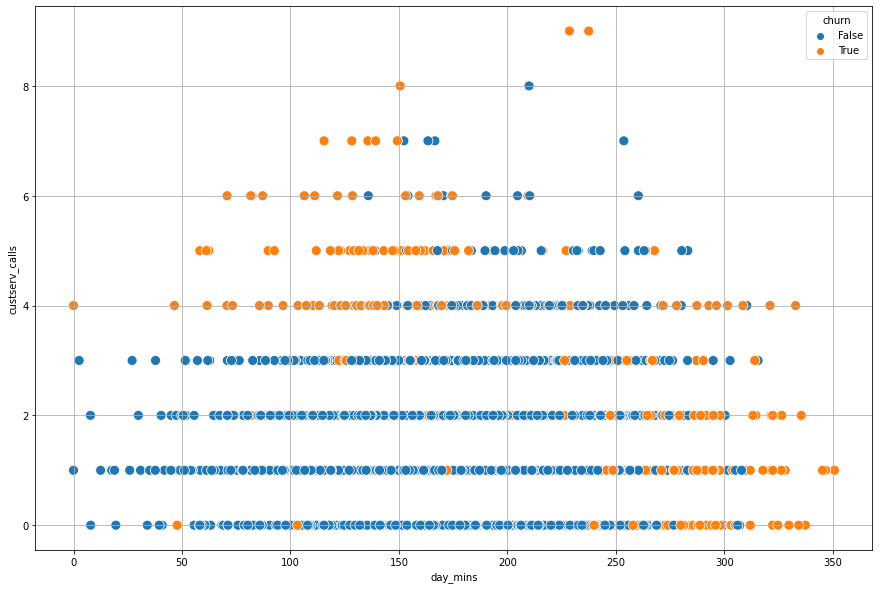

In [5]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = churn, x = 'day_mins', y = 'custserv_calls', hue = 'churn', s = 100)
plt.grid();

In [40]:
tree = DecisionTreeClassifier(max_depth = 2, criterion='entropy')

In [41]:
X = churn[['day_mins', 'custserv_calls']]
y = churn['churn']

In [42]:
tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

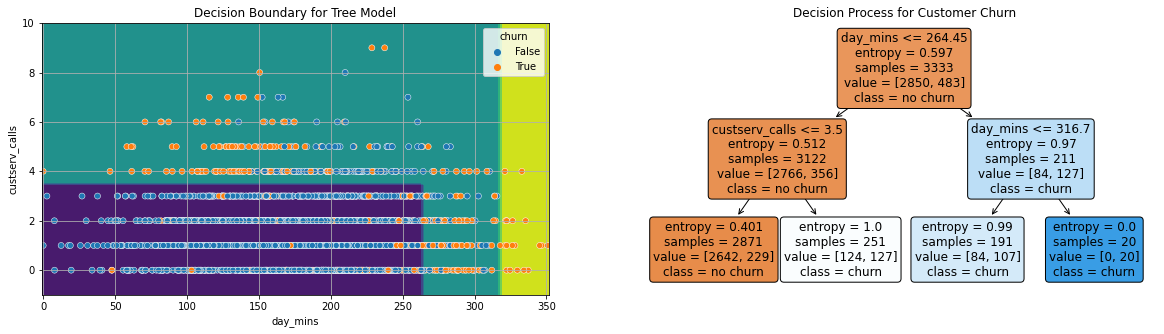

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
DecisionBoundaryDisplay.from_estimator(tree, X, ax = ax[0])
sns.scatterplot(data = X, x = 'day_mins', y = 'custserv_calls', hue = y, ax = ax[0])
ax[0].grid()
ax[0].set_title('Decision Boundary for Tree Model');
plot_tree(tree, feature_names=X.columns,
         filled = True,
         fontsize = 12,
         ax = ax[1],
         rounded = True,
         class_names = ['no churn', 'churn'])
ax[1].set_title('Decision Process for Customer Churn');

#### Titanic Dataset

In [44]:
#load the data
titanic = sns.load_dataset('titanic')
titanic.head(5) #shows first five rows of data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [45]:
#subset the data to binary columns
data = titanic.loc[:4, ['alone', 'adult_male', 'survived']]
data

,alone,adult_male,survived
0,False,True,0
1,False,False,1
2,True,False,1
3,False,False,1
4,True,True,0


Suppose you want to use a single column to predict if a passenger survives or not.  Which column will do a better job predicting survival in the sample dataset above?

### Entropy

One way to quantify the quality of the split is to use a quantity called **entropy**.  This is determined by:

$$H = - \sum p_i \log p_i $$

With a decision tree the idea is to select a feature that produces less entropy.  

In [46]:
#all the same -- probability = 1
1*np.log2(1)

0.0

In [47]:
#half and half -- probability = .5
-(1/2*np.log2(1/2) + 1/2*np.log2(1/2))

1.0

In [48]:
#subset the data to age, pclass, and survived five rows
data = titanic.loc[:4, ['age', 'pclass', 'survived']]
data

,age,pclass,survived
0,22.0,3,0
1,38.0,1,1
2,26.0,3,1
3,35.0,1,1
4,35.0,3,0


In [49]:
#compute entropy for pclass
#first class entropy
first_class_entropy = -(2/2*np.log2(2/2))
first_class_entropy

-0.0

In [50]:
#pclass entropy
third_class_entropy = -(1/3*np.log2(1/3) + 2/3*np.log2(2/3))
third_class_entropy

0.9182958340544896

In [51]:
#weighted sum of these
pclass_entropy = 2/5*first_class_entropy + 3/5*third_class_entropy
pclass_entropy

0.5509775004326937

In [52]:
#splitting on age < 30
entropy_left = -(1/2*np.log2(1/2) + 1/2*np.log2(1/2))
entropy_right = -(1/3*np.log2(1/3) + 2/3*np.log2(2/3))
entropy_age = 2/5*entropy_left + 3/5*entropy_right
entropy_age

0.9509775004326937

In [53]:
#original entropy
original_entropy = -((3/5)*np.log2(3/5) + (2/5)*np.log2(2/5))
original_entropy 

0.9709505944546686

In [54]:
# improvement based on pclass
original_entropy - pclass_entropy

0.4199730940219749

In [55]:
#improvement based on age < 30
original_entropy - entropy_age

0.01997309402197489

#### Using `sklearn`

The `DecisionTreeClassifier` can use `entropy` to build a full decision tree model.  

In [56]:
X = data[['age', 'pclass']]
y = data['survived']

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [58]:
#DecisionTreeClassifier?

In [60]:
#instantiate
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth = 1)

In [61]:
#fit
tree2.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [62]:
#score it
tree2.score(X, y)

0.8

In [63]:
#predictions
tree2.predict(X)

array([0, 1, 0, 1, 0])

#### Visualizing the results

The `plot_tree` function will plot the decision tree model after fitting.  There are many options you can use to control the resulting tree drawn.

In [29]:
from sklearn.tree import plot_tree

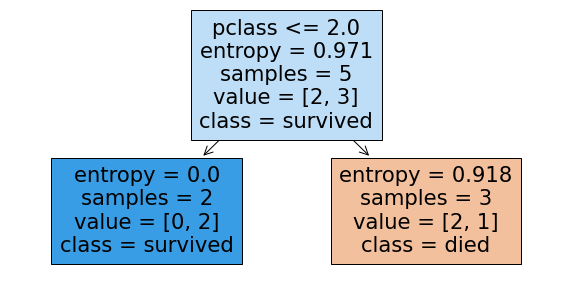

In [64]:
#plot_tree
fig, ax = plt.subplots(figsize = (10, 5))
plot_tree(tree2, 
          feature_names=X.columns, 
          class_names=['died', 'survived'], filled = True);

**PROBLEM**

Build a Logistic Regression pipeline to predict purchase. 

In [65]:
purchase_data = pd.read_csv('https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Customer%20Purchase.csv')

In [66]:
purchase_data.head()

,Customer ID,Age,Gender,Education,Review,Purchased
0,1021,30,Female,School,Average,No
1,1022,68,Female,UG,Poor,No
2,1023,70,Female,PG,Good,No
3,1024,72,Female,PG,Good,No
4,1025,16,Female,UG,Average,No


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [108]:
encoder = make_column_transformer((OneHotEncoder(), ['Gender', 'Education', 'Review']),
                                 remainder = 'passthrough',
                                 verbose_feature_names_out=False)
model = ''
lgr_pipe = Pipeline([('transform', encoder), ('model', LogisticRegression())])

In [109]:
X = purchase_data.iloc[:, 1:-1]
y = purchase_data['Purchased']

In [110]:
lgr_pipe.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Education',
                                                   'Review'])],
                                   verbose_feature_names_out=False)),
                ('model', LogisticRegression())])

In [111]:
lgr_pipe.score(X, y)

0.56

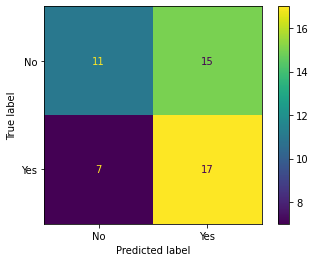

In [112]:
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X, y)

**Problem**

Build a `DecisionTreeClassifier` pipeline to predict purchase.

In [113]:
tree_pipe = Pipeline([('transform', encoder), ('model', DecisionTreeClassifier(max_depth = 4))])

In [114]:
tree_pipe.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Education',
                                                   'Review'])],
                                   verbose_feature_names_out=False)),
                ('model', DecisionTreeClassifier(max_depth=4))])

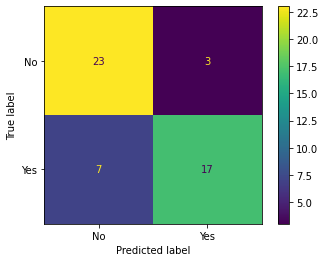

In [115]:
ConfusionMatrixDisplay.from_estimator(tree_pipe, X, y)

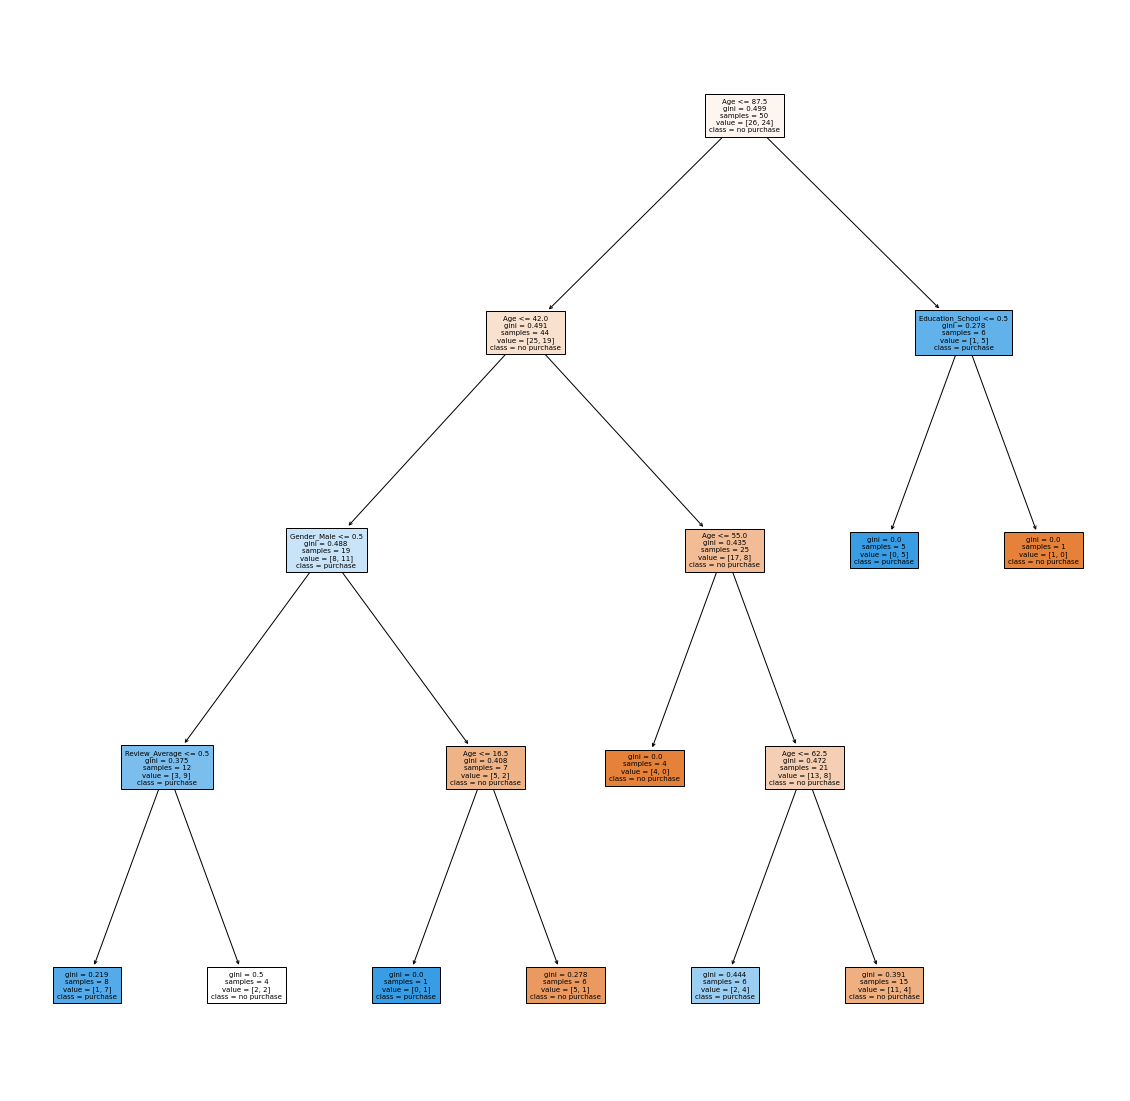

In [116]:
plt.figure(figsize = (20, 20))
plot_tree(tree_pipe['model'], feature_names=tree_pipe['transform'].get_feature_names_out(),
         class_names = ['no purchase', 'purchase'],
         filled = True,
         fontsize=7);

**Extra Problem**

Suppose you are only able to target 50% of your customers with an advertising incentive.  If you only target the highest probability of purchases, which of the models provides the biggest "lift" over the baseline? (Percent of positive purchases) Lift values and argument in slack.

In [117]:
#predict proba for positive class


In [118]:
#sort by probability


In [119]:
#percent of positives on first 50%?


**Problem**

For next class, read the chapter "Decision Analytic Thinking: What's a Good Model?" from *Data Science for Business*.  Pay special attention to the cost benefit analysis.  You will be asked to use cost/benefit analysis to determine the "best" classifier for an example dataset next class.



![](images/costben.png)

In [147]:
#example cost benefit matrix
cost_benefits = np.array([ [0, -1], [0, 99]])
cost_benefits

array([[ 0, -1],
       [ 0, 99]])

The **expected value** is computed by:

$$\text{Expected Profit} = p(Y,p)*b(Y, p) + p(N, p)*b(N,p) + p(N,n)*b(N,n) + p(Y,n)*b(Y,n)$$

use this to calculate the expected profit of the Decision Tree and Logistic Regression model.  Which is better?  Expected Value and argument in slack.

In [148]:
from sklearn.metrics import confusion_matrix

In [164]:
mat = confusion_matrix(y, tree_pipe.predict(X))

In [165]:
mat

array([[23,  3],
       [ 7, 17]])

In [166]:
mat.sum()

50

In [172]:
#expected profit for decision tree model
(((mat/mat.sum())*cost_benefits)).sum()

33.6

In [173]:
lgr_mat = confusion_matrix(y, lgr_pipe.predict(X))

In [174]:
lgr_mat/lgr_mat.sum()

array([[0.22, 0.3 ],
       [0.14, 0.34]])

In [175]:
#expected profit for logistic model
((lgr_mat/lgr_mat.sum())*cost_benefits).sum()

33.36000000000001